## Example of SnowCam image anlaysis using python tools available in Sci-kit image.

### The purpose of this segment of code is to recognize particles in an image, and then count and measure them.

## Step one: import the image and a mask for the edges

<IPython.core.display.Javascript object>


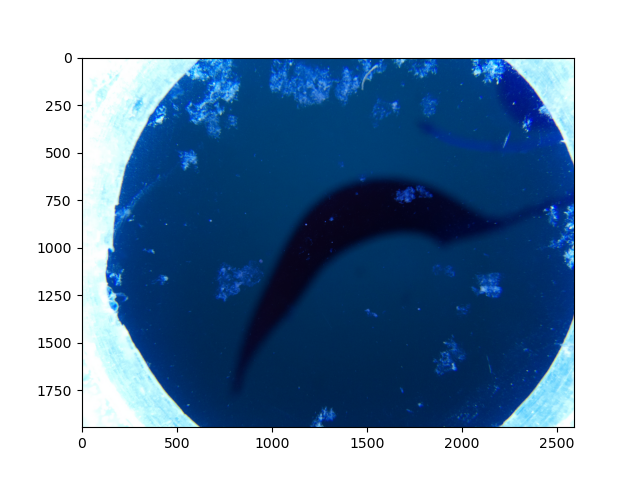

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skimage import io, color, util, exposure, feature, morphology,measure
import matplotlib.pyplot as plt
import os
import scipy.ndimage as ndi
import cv2

from skimage.filters import sobel, threshold_otsu, threshold_multiotsu

im_path='/Users/cdurkin/Data/Images/SnowCam/SnowCam_EXPORTS_NA/raw/'

example_photo='114-2021-05-23_15-07-57.jpg'

photo = io.imread(os.path.join(im_path,example_photo),plugin='pil')
mask=io.imread('/Users/cdurkin/Projects/SnowCam/SnowCam_mask.jpg',plugin='pil')
plt.imshow(photo)

# Use the pixel values and Mask out the edges

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_38420/3108152551.py:1: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  mask=util.img_as_ubyte(color.rgb2grey(mask))


<IPython.core.display.Javascript object>


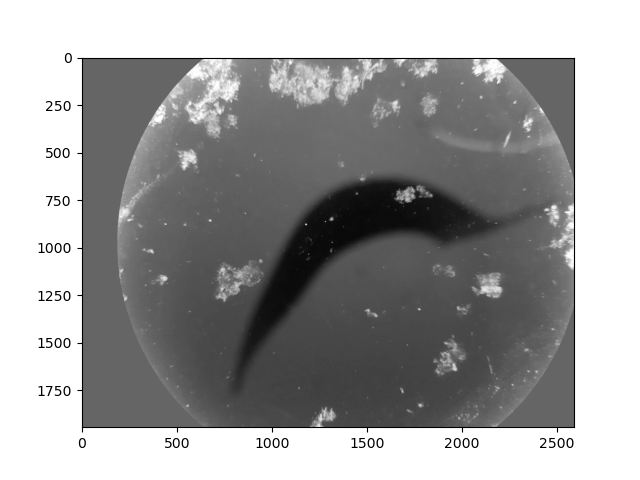

In [2]:
mask=util.img_as_ubyte(color.rgb2grey(mask))
photo_hsv=color.rgb2hsv(photo)
photo_value=photo_hsv[:,:,2]

photo_value[mask==255]=np.median(photo_value)
plt.figure()
plt.imshow(photo_value,cmap=plt.cm.gray)


## Background subtraction

Remove background using gaussian blur of the fast fourier transform
sigma is the size of the standard deviation of the gaussian blur. I chose 2 after testing values for these images. This should blur fairly large particles into the background, and enable them to still be detected (not subtracted with the background).

Also need to add artificial "pad" to the edges of the image so that the gaussian blur does not produces artifacts at the edges of the image. I just repeated the edge rows and columns 100 times along the edges

First make the "padded" image, apply the FFT, use FFT-shift, multiply by the gaussian blur kernal which is the same dimensions as the padded image, inverse shift, and inverse FFT the image. Trim off the padding. Result is gaussian blur of the image. Do this for both the greyscale and the brown-highlighted versions of the image.


<IPython.core.display.Javascript object>


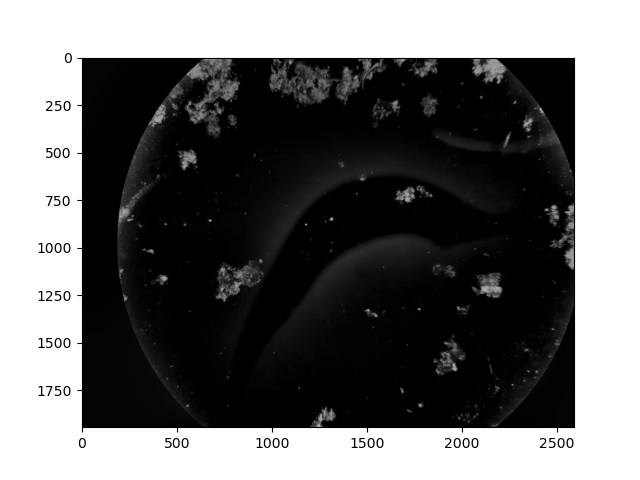

In [3]:
def fft_function(photo):
    sigma=4
    pad=100
    top_padding=np.array(np.zeros_like(photo[0:pad,:]))
    top_padding[:,:]=photo[0,:]
    bottom_padding=np.array(np.zeros_like(photo[0:pad,:]))
    bottom_padding[:,:]=photo[np.shape(photo)[0]-1,:]
    padded_photo=np.concatenate((top_padding,np.array(photo),bottom_padding))
    left_padding=np.array(np.zeros_like(padded_photo[:,0:pad]))
    left_padding=np.transpose(left_padding)
    left_padding[:,:]=padded_photo[:,0]
    left_padding=np.transpose(left_padding)
    right_padding=np.array(np.zeros_like(padded_photo[:,0:pad]))
    right_padding=np.transpose(right_padding)
    right_padding[:,:]=padded_photo[:,np.shape(photo)[1]-1]
    right_padding=np.transpose(right_padding)
    padded_photo=np.concatenate((left_padding,padded_photo,right_padding),axis=1)
    photo_dimensions=np.shape(padded_photo)
    nrows=photo_dimensions[1]
    ncols=photo_dimensions[0]
    cy, cx = ncols/2, nrows/2
    x = np.linspace(0, nrows, nrows)
    y = np.linspace(0, ncols, ncols)
    X, Y = np.meshgrid(x, y)
    gmask = np.exp(-(((X-cx)/sigma)**2 + ((Y-cy)/sigma)**2))
    photo_fft = np.fft.fft2(padded_photo) #disk shape over which median value is calculated must be larger than the largest particle
    photo_fft=np.fft.fftshift(photo_fft)
    blur_image=photo_fft*gmask
    blur_image_dimensions=np.shape(blur_image)
    photo_ifftshifted=np.fft.ifftshift(blur_image)
    photo_ifft = np.fft.ifft2(photo_ifftshifted)
    photo_ifft_trimmed=photo_ifft[pad:blur_image_dimensions[0]-pad,pad:blur_image_dimensions[1]-pad]
#    photo_fft_diff = np.abs(photo_ifft_trimmed) - np.median(photo) ##by subtracting the median value here, we maintain the same median brightness in the background subtracted image.
#    photo_nobg = photo-photo_fft_diff
    photo_nobg=photo-np.abs(photo_ifft_trimmed)
    return(photo_nobg)


photo_grey_nobg=fft_function(photo_value)

photo_grey_nobg=util.img_as_ubyte(photo_grey_nobg)

plt.figure()
plt.imshow(np.abs(photo_grey_nobg),cmap=plt.cm.gray)



## threshold brightest pixels

<IPython.core.display.Javascript object>


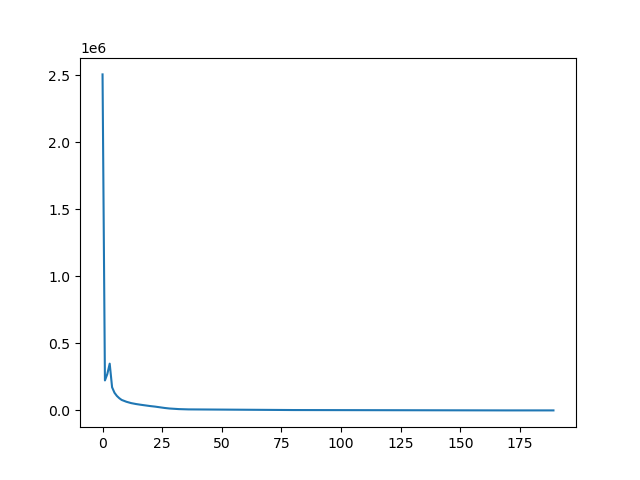

In [4]:
histo = exposure.histogram(photo_grey_nobg)
plt.figure()
plt.plot(histo[1],histo[0])




<IPython.core.display.Javascript object>


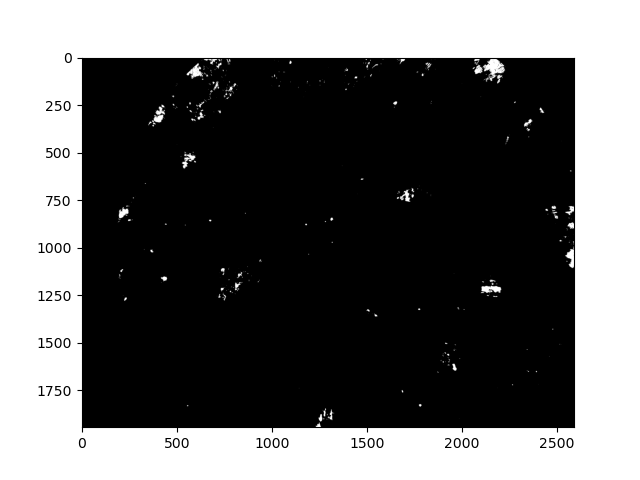

In [5]:
markers = np.zeros_like(photo_grey_nobg)
markers[photo_grey_nobg >np.mean(photo_grey_nobg)+5*np.std(photo_grey_nobg)] = 255

plt.figure()
plt.imshow(markers,cmap=plt.cm.gray)



## Also find edges using the Canny edge detector and merge those edge pixels with the marker pixels identified above.  Then fill in the holes, perform a "dilation" and fill the holes again, then perform an erosion to correct for the dilation.  Combing global thresholding, edge detection, and dilation/erosion is needed to find the entire area of the particles.

## Will need to mask out edges of the imaging surface since it is a giant edge 

<IPython.core.display.Javascript object>


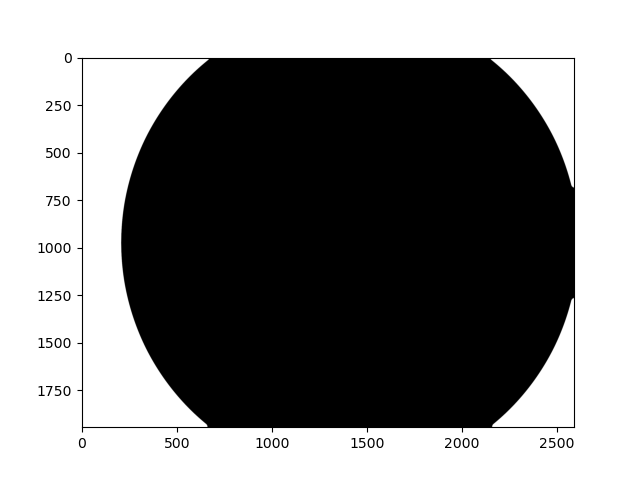

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [6]:
eroded_mask = morphology.dilation(mask, selem = morphology.disk(20))


plt.figure()
plt.imshow(eroded_mask,cmap='gray')
eroded_mask

<IPython.core.display.Javascript object>


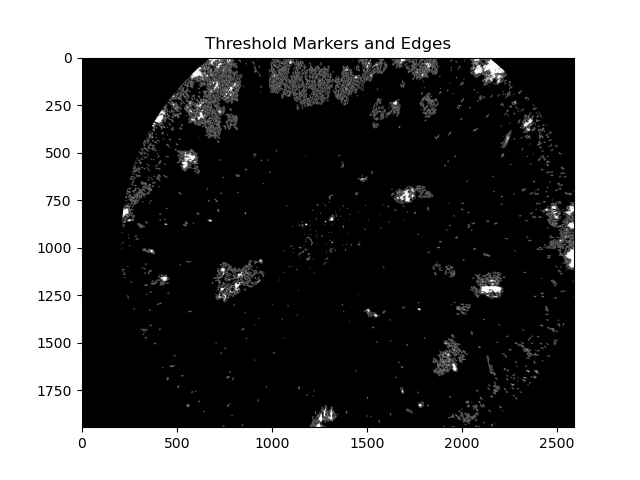

<IPython.core.display.Javascript object>


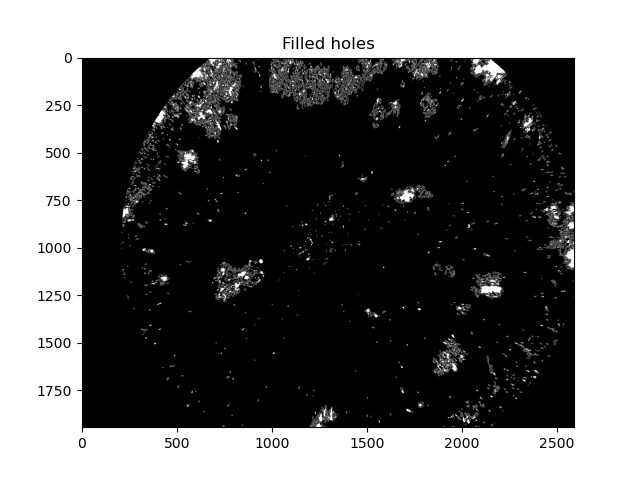

<IPython.core.display.Javascript object>


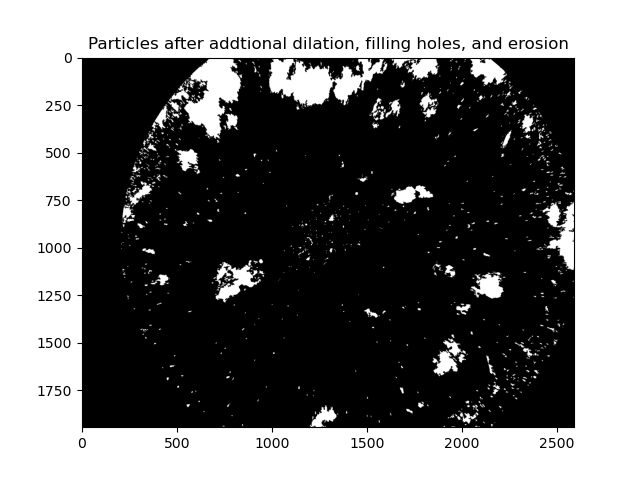

Text(0.5, 1.0, 'Particles after addtional dilation, filling holes, and erosion')

In [7]:
photo_canny=cv2.Canny(photo,30,100)
photo_particles=markers.copy()
photo_particles[photo_canny==255]=255

photo_particles[eroded_mask==255]=0
plt.figure()
plt.imshow(photo_particles,cmap='gray')
plt.title('Threshold Markers and Edges')
photo_particles_filled=ndi.morphology.binary_fill_holes(photo_particles)
photo_particles_filled1=morphology.dilation(photo_particles_filled, selem = morphology.disk(1))
photo_particles_filled1=ndi.morphology.binary_fill_holes(photo_particles_filled1)
photo_particles_filled2=morphology.erosion(photo_particles_filled1, selem = morphology.disk(1))
plt.figure()
plt.imshow(photo_particles_filled,cmap='gray')
plt.title('Filled holes')
plt.figure()
plt.imshow(photo_particles_filled2,cmap='gray')
plt.title('Particles after addtional dilation, filling holes, and erosion')

## Measure particles

In [8]:
particle_image=util.img_as_ubyte(photo_particles_filled2)
labeled_particles,_ =ndi.label(particle_image)
properties = measure.regionprops(labeled_particles)

In [9]:
properties

 ...]

## Show example of how well particles were detected in the image

In [10]:
particle_edges=cv2.Canny(particle_image,100,200)
Value_color=util.img_as_ubyte(color.gray2rgb(photo_value))
Value_color[particle_edges==255]=[255,0,127]

<IPython.core.display.Javascript object>


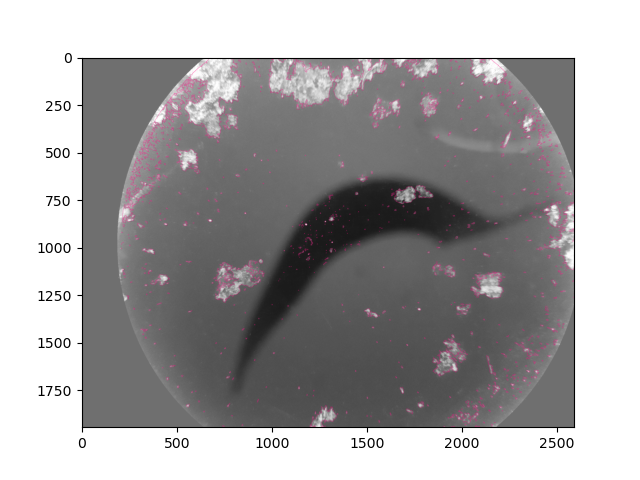

In [11]:
plt.figure()
plt.imshow(Value_color)